<a href="https://colab.research.google.com/github/smritip/dtw-for-classical-music-prod/blob/master/dtw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

from matplotlib import pyplot as plt
import IPython.display as ipd

from chroma import wav_to_chroma

In [0]:
# Create cost matrix between two sequences x and y, using cosine distance.
def get_cost_matrix(x, y) :
    N = x.shape[1]
    M = y.shape[1]
    max_range= max(N, M)
    cost = np.empty((N, M))
    for i in range(N):
        for j in range(M):
            cost[i, j] = 1 - np.true_divide(np.dot(x[:, i], y[:, j]), (np.linalg.norm(x[:, i]) * np.linalg.norm(y[:, j])))
    
    return cost

In [0]:
# Calculate the accumulated cost and backtracking matrices based on the cost matrix.
def run_dtw(C):
    n = C.shape[0]
    m = C.shape[1]
    D = np.empty((n, m))
    
    # each entry in B will be like a "pointer" to the point it came from
    # (0 = origin, 1 = from left, 2 = from diagonal, 3 = from below)
    B = np.empty((n, m))
    
    # initialize origin
    D[0, 0] = C[0, 0]
    B[0, 0] = 0
    
    # initialize first column
    cost = C[0, 0]
    for i in range(1, n):
        cost += C[i, 0]
        D[i, 0] = cost
        B[i, 0] = 3
    
    # initialize first row
    cost = C[0, 0]
    for i in range(1, m):
        cost += C[0, i]
        D[0, i] = cost
        B[0, i] = 1
    
    # calculate accumulated cost for rest of matrix
    for i in range(1, n):
        for j in range(1, m):
            p_costs = [(i-1, j), (i, j-1), (i-1, j-1)]
            min_cost = D[p_costs[0][0], p_costs[0][1]]
            min_indices = p_costs[0]
            for k in range(1, len(p_costs)):
                c = D[p_costs[k][0], p_costs[k][1]]
                if c < min_cost:
                    min_cost = D[p_costs[k][0], p_costs[k][1]]
                    min_indices = p_costs[k]
        
            D[i, j] = min_cost + C[i, j]
            
            ptr = {(i-1, j): 3, (i, j-1): 1, (i-1, j-1): 2}
            B[i, j] = ptr[min_indices]
            
    return D, B

In [0]:
# Return a path from the backtraing matrix B. 
# Return this as an np.array that is an Lx2 matrix (where L is the length of the path)
def find_path(B) :
    n = B.shape[0]
    m = B.shape[1]
    current = (n-1, m-1)
    path = [current]
    goal = (0, 0)
    while current != goal:
        ptr = B[current[0], current[1]]

        if ptr == 1:  # go left
            next_pt = (current[0], current[1] - 1)    
        elif ptr == 2:  # go diagonal
            next_pt = (current[0] - 1, current[1] - 1)
        elif ptr == 3:  # go down
            next_pt = (current[0] - 1, current[1])
            
        path.append(next_pt)
        current = next_pt
    
    path.reverse()
        
    return path

# Testing

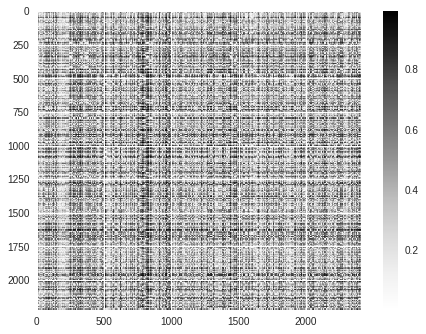

In [5]:
chroma_x = wav_to_chroma("maroon5_thislove_og.wav")
chroma_y = wav_to_chroma("maroon5_thislove_acoustic.wav")
cost_xy = get_cost_matrix(chroma_x, chroma_y)
plt.imshow(cost_xy)
plt.colorbar()

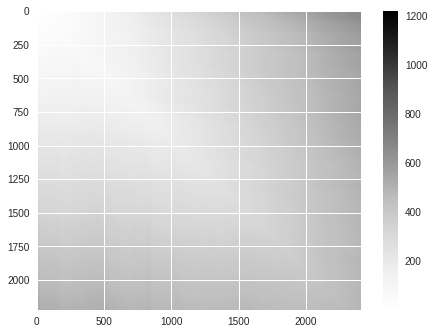

In [6]:
D, B = run_dtw(cost_xy)
plt.imshow(D)
plt.colorbar()

(0, 2221)

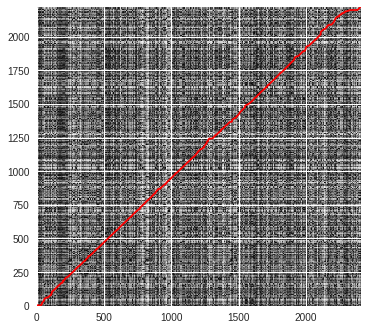

In [7]:
path = find_path(B)
plt.imshow(cost_xy, origin='lower', interpolation='nearest', cmap='gray')
path = np.array(path)
plt.plot(path[:,1], path[:,0], '-r');
plt.xlim(0, cost_xy.shape[1])
plt.ylim(0, cost_xy.shape[0])